# Wczytywanie danych

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import timedelta

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [2]:
DATA_DIR = 'data'

In [3]:
data_files = os.listdir(DATA_DIR)
data_files

['users.jsonl', 'deliveries.jsonl', 'sessions.jsonl', 'products.jsonl']

In [4]:
df_users = pd.read_json(os.path.join(DATA_DIR, data_files[0]), lines=True)
df_deliveries = pd.read_json(os.path.join(DATA_DIR, data_files[1]), lines=True)
df_sessions = pd.read_json(os.path.join(DATA_DIR, data_files[2]), lines=True)
df_products = pd.read_json(os.path.join(DATA_DIR, data_files[3]), lines=True)

# Wybór danych

In [5]:
df_sessions.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2020-01-25 19:25:15,102,1538,VIEW_PRODUCT,5.0,NaN
1,124,2020-01-25 19:26:12,102,1542,VIEW_PRODUCT,5.0,NaN
2,124,2020-01-25 19:30:49,102,1539,VIEW_PRODUCT,5.0,NaN
3,124,2020-01-25 19:35:40,102,1541,VIEW_PRODUCT,5.0,NaN
4,124,2020-01-25 19:39:26,102,1547,VIEW_PRODUCT,5.0,NaN


- Users

In [6]:
df_users.head()

,user_id,name,city,street
0,102,Sebastian Młyńczak,Szczecin,pl. Pałacowa 584
1,103,Karina Dąbrowicz,Radom,plac Polna 13
2,104,Konrad Żelazek,Wrocław,al. Młyńska 53/86
3,105,Bruno Baumgart,Szczecin,plac Narcyzowa 29
4,106,Karina Grygorowicz,Poznań,ul. Chopina 24


In [7]:
df_deliveries.head()

,purchase_id,purchase_timestamp,delivery_timestamp,delivery_company
0,20001,2020-01-25T19:40:37,2020-01-30T19:40:44,516
1,20002,2019-12-29T16:12:47,2019-12-31T16:13:40,516
2,20003,2020-12-30T07:28:26,2021-01-01T07:29:45,516
3,20004,2020-04-13T06:30:14,2020-04-16T06:33:45,620
4,20005,2022-03-15T11:36:49,2022-03-20T11:38:02,516


- Products

In [8]:
df_products.head()

,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
0,1001,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",619.99,Sofotel,19.0,{}
1,1002,Fotel gamingowy Sofotel Cerber,"Akcesoria (Laptop, PC);Fotele gamingowe",599.99,Sofotel,19.0,{}
2,1003,Fotel gamingowy TopEshop DORY,"Akcesoria (Laptop, PC);Fotele gamingowe",379.00,TopEshop,30.0,{}
3,1004,Fotel gamingowy Diablo Chairs WHITE BIEL BIAŁY,"Akcesoria (Laptop, PC);Fotele gamingowe",197.00,Diablo Chairs,30.0,{}
4,1005,Fotel gamingowy STERNHOFF SDH 162 B+B,"Akcesoria (Laptop, PC);Fotele gamingowe",399.00,STERNHOFF,17.0,{}


## Zbadanie rozkładu danych

Sprawdzenie, czy wszystkie przeglądane produkty znajdują się w bazie

In [9]:
for prod_id in df_sessions['product_id'].unique():
    if prod_id not in df_products['product_id'].unique():
        print('Product not in database', prod_id)

In [10]:
fig = make_subplots(1, 2, subplot_titles=('Price [PLN]', 'Weight [kg]'))

fig.add_trace(
    go.Histogram(x=df_products['price'], name='price'), row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df_products['weight_kg'], name='weight'), row=1, col=2
)

fig.update_yaxes(title_text='Count')
fig.update_layout(title_text='Distribution of feature values')
fig.show()

Oba rozkłady są rozkładami z długim ogonem, jednak w przypadku cen zachowana jest ciągłość wartości. W przypadku wag produktów prawdopodobnie mamy do czynienia z błędnymi wartościami odstającymi. Zbadajmy je.

In [11]:
px.box(df_products, y=['price', 'weight_kg'], title='Feature values')


In [12]:
fig = go.Figure()

fig.add_trace(go.Box(x=df_products['weight_kg'], name='weight [kg]'))
fig.update_layout(title_text='Distribution of the weight_kg feature')

In [13]:
incorrect_weight_products = df_products[df_products['weight_kg'] > 50]
incorrect_weight_products


,product_id,product_name,category_path,price,brand,weight_kg,optional_attributes
321,1322,Myszka bezprzewodowa Marvo M729W sensor optyczny,Myszki;Bezprzewodowe,69.99,Marvo,225.0,{'color': 'czarny'}
325,1326,Myszka bezprzewodowa Logitech inny sensor opty...,Myszki;Bezprzewodowe,162.52,Logitech,91.0,{'color': 'czarny'}
330,1331,Myszka bezprzewodowa iMICE E-1300 sensor laserowy,Myszki;Bezprzewodowe,44.89,iMICE,110.0,{'color': 'czarny'}
365,1366,Myszka bezprzewodowa Logitech G600 sensor lase...,Myszki;Bezprzewodowe,259.00,Logitech,300.0,{'color': 'czarny'}
416,1417,Myszka bezprzewodowa Logitech M187 sensor opty...,Myszki;Bezprzewodowe,49.00,Logitech,51.9,{'color': 'wielokolorowy'}


In [14]:
fig = go.Figure()

fig.add_trace(go.Box(
    x=df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'], name='weight [kg]'))

fig.update_layout(title_text='Distribution of the weight_kg feature for "Myszki;Bezprzewodowe" category')


In [15]:
incorrect_weight_products['product_name'].unique()

array(['Myszka bezprzewodowa Marvo M729W sensor optyczny',
       'Myszka bezprzewodowa Logitech inny sensor optyczny',
       'Myszka bezprzewodowa iMICE E-1300 sensor laserowy',
       'Myszka bezprzewodowa Logitech G600 sensor laserowy',
       'Myszka bezprzewodowa Logitech M187 sensor optyczny'], dtype=object)

Rzeczywiście, w powyszych danych widnieje błąd związany z wagą myszek, która została prawdopodobnie źle wprowadzona. W związku z tym, ze liczba produktów których błąd dotyczy nie jest duza, ręcznie poprawimy dane korzystając z oficjalnych danych producentów myszek.


- Myszka bezprzewodowa Marvo M729W sensor optyczny: 107 g = 0.107 kg
- Myszka bezprzewodowa iMICE E-1300 sensor laserowy: 68g = 0.068 kg
- Myszka bezprzewodowa Logitech G600 sensor laserowy: 133 g = 0.133 kg
- Myszka bezprzewodowa Logitech M187 sensor optyczny: 51.9 g ~ 0.052 kg
- Myszka bezprzewodowa Logitech inny sensor optyczny: Tutaj przyjmiemy medianę wag pozostałych produktów z kategorii `Myszki;Bezprzewodowe`

In [16]:
df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'].median()


0.18

In [17]:
df_products.loc[df_products['product_id'] == 1322, 'weight_kg'] = 0.107
df_products.loc[df_products['product_id'] == 1331, 'weight_kg'] = 0.068
df_products.loc[df_products['product_id'] == 1366, 'weight_kg'] = 0.133
df_products.loc[df_products['product_id'] == 1417, 'weight_kg'] = 0.052
df_products.loc[df_products['product_id'] == 1326,
                'weight_kg'] = df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'].median()



Po poprawieniu błędów:

In [18]:
fig = go.Figure()

fig.add_trace(go.Box(
    x=df_products[df_products['category_path'] == 'Myszki;Bezprzewodowe']['weight_kg'], name='weight [kg]'))

fig.update_layout(title_text='Distribution of the weight_kg feature for "Myszki;Bezprzewodowe" category after fixing values')


In [19]:
fig = go.Figure()

fig.add_trace(go.Box(x=df_products['weight_kg'], name='weight [kg]'))

fig.update_layout(title_text='Distribution of the weight_kg feature after fixing values')


## Połączenie danych

Filtracja `sesji`, w których nie nastąpił zakup lub zwrot

&darr;

Połączenie wybranych `sesji` z `produktami`

&darr;

Połączenie z `uzytkownikami`

&darr;

Połączenie z `dostawami`

In [20]:
df_sessions_filtered = df_sessions[~df_sessions['purchase_id'].isna()]

df_sessions_filtered.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
6,124,2020-01-25 19:40:37.000000,102,1546,BUY_PRODUCT,5.0,20001.0
7,125,2020-02-08 09:00:56.623825,102,1546,RETURN_PRODUCT,NaN,20001.0
14,126,2019-12-29 16:12:47.000000,102,1616,BUY_PRODUCT,5.0,20002.0
16,127,2020-12-30 07:28:26.000000,102,1151,BUY_PRODUCT,0.0,20003.0
20,128,2020-04-13 06:30:14.000000,102,1633,BUY_PRODUCT,5.0,20004.0


In [21]:
df_sessions_filtered.shape, df_products.shape, df_users.shape, df_deliveries.shape


((15859, 7), (653, 7), (400, 4), (14198, 4))

In [22]:
df_concat = pd.merge(left=df_sessions_filtered,
                     right=df_products, on='product_id', how='left')
df_concat = pd.merge(left=df_concat, right=df_users, on='user_id', how='left')
df_concat = pd.merge(left=df_concat, right=df_deliveries,
                     on='purchase_id', how='left')

df_concat.head(), df_concat.shape

(   session_id                  timestamp  user_id  product_id      event_type  \
 0         124 2020-01-25 19:40:37.000000      102        1546     BUY_PRODUCT   
 1         125 2020-02-08 09:00:56.623825      102        1546  RETURN_PRODUCT   
 2         126 2019-12-29 16:12:47.000000      102        1616     BUY_PRODUCT   
 3         127 2020-12-30 07:28:26.000000      102        1151     BUY_PRODUCT   
 4         128 2020-04-13 06:30:14.000000      102        1633     BUY_PRODUCT   
 
    offered_discount  purchase_id  \
 0               5.0      20001.0   
 1               NaN      20001.0   
 2               5.0      20002.0   
 3               0.0      20003.0   
 4               5.0      20004.0   
 
                                     product_name  \
 0             Pamięć RAM Goodram DDR4 16 GB 3600   
 1             Pamięć RAM Goodram DDR4 16 GB 3600   
 2  Pad bezprzewodowy Esperanza EGG108G GLADIATOR   
 3          Komputer stacjonarny Dell Vostro 3888   
 4               

Sprawdzenie poprawności łączenia danych

In [23]:
df_concat.isna().sum()

session_id                0
timestamp                 0
user_id                   0
product_id                0
event_type                0
offered_discount       1661
purchase_id               0
product_name              0
category_path             0
price                     0
brand                     0
weight_kg                 0
optional_attributes       0
name                      0
city                      0
street                    0
purchase_timestamp        0
delivery_timestamp        0
delivery_company          0
dtype: int64

Wszystko przebiegło pomyślnie

## Filtracja wybranych danych do modelu

### Wstępne dane wejściowe:
*   Sessions:
> *   timestamp
> *   event_type
*   Products:
> *   category_path
> *   price
> *   brand
> *   weight_kg
*   Users:
> *   city

Dodatkowe dane wejściowe, które zostaną wykorzystane w przypadku nie uzyskania zadowalających wyników przez model:
*   Products:
> *   product_id
*   Users:
> *   user_id

In [24]:
df_concat.columns


Index(['session_id', 'timestamp', 'user_id', 'product_id', 'event_type',
       'offered_discount', 'purchase_id', 'product_name', 'category_path',
       'price', 'brand', 'weight_kg', 'optional_attributes', 'name', 'city',
       'street', 'purchase_timestamp', 'delivery_timestamp',
       'delivery_company'],
      dtype='object')

In [25]:
chosen_columns = ['timestamp', 'event_type', 'category_path', 'price', 'brand',
                  'weight_kg', 'city', 'purchase_timestamp', 'delivery_timestamp']

df_concat_chosen = df_concat[chosen_columns]
df_concat_chosen.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city,purchase_timestamp,delivery_timestamp
0,2020-01-25 19:40:37.000000,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25T19:40:37,2020-01-30T19:40:44
1,2020-02-08 09:00:56.623825,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25T19:40:37,2020-01-30T19:40:44
2,2019-12-29 16:12:47.000000,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin,2019-12-29T16:12:47,2019-12-31T16:13:40
3,2020-12-30 07:28:26.000000,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin,2020-12-30T07:28:26,2021-01-01T07:29:45
4,2020-04-13 06:30:14.000000,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin,2020-04-13T06:30:14,2020-04-16T06:33:45


Transformacja (zaokrąglenie) timestampów na dni

In [28]:
df_concat_chosen[['timestamp', 'purchase_timestamp', 'delivery_timestamp']] = df_concat_chosen[['timestamp', 'purchase_timestamp', 'delivery_timestamp']].apply(
    pd.to_datetime).apply(lambda x: x.dt.date)

df_concat_chosen.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15859 entries, 0 to 15858
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           15859 non-null  object 
 1   event_type          15859 non-null  object 
 2   category_path       15859 non-null  object 
 3   price               15859 non-null  float64
 4   brand               15859 non-null  object 
 5   weight_kg           15859 non-null  float64
 6   city                15859 non-null  object 
 7   purchase_timestamp  15859 non-null  object 
 8   delivery_timestamp  15859 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.2+ MB


/var/folders/_1/grmv219n3mzbyfj882m03j3c0000gn/T/ipykernel_4001/3909416349.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [29]:
df_concat_chosen.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city,purchase_timestamp,delivery_timestamp
0,2020-01-25,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
2,2019-12-29,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin,2019-12-29,2019-12-31
3,2020-12-30,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin,2020-12-30,2021-01-01
4,2020-04-13,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin,2020-04-13,2020-04-16


### Czas dostawy w przypadku kupna

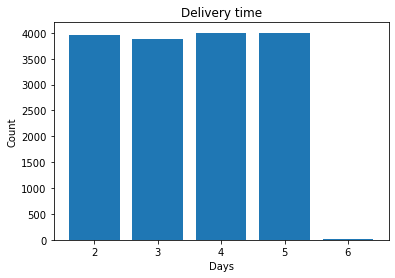

4    4003
5    3995
2    3963
3    3888
6      10
dtype: int64


In [30]:
delivery_days = (df_concat_chosen['delivery_timestamp'] - df_concat_chosen['purchase_timestamp']).dt.days
plt.bar(delivery_days.value_counts().keys(), delivery_days.value_counts())

plt.xlabel('Days')
plt.ylabel('Count')
plt.title("Delivery time")
plt.show()

print(delivery_days.value_counts())


In [31]:
median_delivery_days = np.median(delivery_days)
print(f'Median delivery days: {median_delivery_days}')


Median delivery days: 4.0


Powyzsza wartość zostanie wykorzystana w celu oszacowania ilości zwrotów przychodzącychh do magazynu dango dnia

In [ ]:
df_concat_chosen.head()

,timestamp,event_type,category_path,price,brand,weight_kg,city,purchase_timestamp,delivery_timestamp
0,2020-01-25,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin,2020-01-25,2020-01-30
2,2019-12-29,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin,2019-12-29,2019-12-31
3,2020-12-30,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin,2020-12-30,2021-01-01
4,2020-04-13,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin,2020-04-13,2020-04-16


### Usunięcie zbędnych kolumn po kalkulacji

In [32]:
df_concat_chosen = df_concat_chosen.drop(['purchase_timestamp', 'delivery_timestamp'], axis=1)
df_concat_chosen.head()



,timestamp,event_type,category_path,price,brand,weight_kg,city
0,2020-01-25,BUY_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
2,2019-12-29,BUY_PRODUCT,Urządzenia wskazujące;Pady,29.19,Esperanza,0.300,Szczecin
3,2020-12-30,BUY_PRODUCT,Komputery;Komputery stacjonarne,629.74,Dell,0.000,Szczecin
4,2020-04-13,BUY_PRODUCT,Zestaw klawiatura i mysz;Bezprzewodowe,197.00,Logitech,0.875,Szczecin


In [34]:
event_type_history_count = df_concat_chosen[['timestamp', 'event_type']].groupby(
    ['timestamp', 'event_type']).agg({'event_type': 'count'})

event_type_history_count.columns = ['count']

event_type_history_count = event_type_history_count.reset_index()
event_type_history_count


,timestamp,event_type,count
0,2019-08-01,BUY_PRODUCT,15
1,2019-08-02,BUY_PRODUCT,19
2,2019-08-03,BUY_PRODUCT,14
3,2019-08-04,BUY_PRODUCT,17
4,2019-08-05,BUY_PRODUCT,15
...,...,...,...
1622,2022-04-11,BUY_PRODUCT,15
1623,2022-04-12,BUY_PRODUCT,7
1624,2022-04-13,RETURN_PRODUCT,1
1625,2022-04-16,RETURN_PRODUCT,1


# EDA

Wizualizacja ilości zwrotów z całego dostępnego okresu 

In [35]:
px.line(event_type_history_count, x='timestamp', y='count', color='event_type', title='Number of events')


W powyzszych danych występuje **sezonowość**, co moze pozytywnie wpłynąć na późniejsze tworzenie modelu.

### Czy ilość zamówień koreluje z ilością zwrotów?

Sprawdzenie, czy ilość zwracanych towarów koreluje z ilością zakupów na stronie

                           event_type_BUY_PRODUCT  event_type_RETURN_PRODUCT
event_type_BUY_PRODUCT                   1.000000                   0.030366
event_type_RETURN_PRODUCT                0.030366                   1.000000


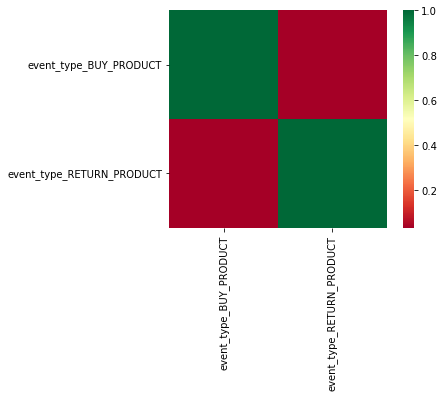

In [36]:
corr_matrix = pd.get_dummies(df_concat_chosen[['timestamp', 'event_type']], columns=['event_type']).groupby('timestamp').sum().corr()

sns.heatmap(corr_matrix, square=True, cmap='RdYlGn')
print(corr_matrix)


Korelacja jest praktycznie zerowa w związku z czym na początkowym etapie modelowania pominiemy ilość składanych zamówień

## Przygotowanie danych do modelowania

## Model 1 (Naive) - bazujący wyłącznie na historii zwrotów

### Usuniecie sesji kupna `event_type`: `BUY_PRODUCT`

In [39]:
df_returns = df_concat_chosen[df_concat_chosen['event_type'] == 'RETURN_PRODUCT']
df_returns.head()


,timestamp,event_type,category_path,price,brand,weight_kg,city
1,2020-02-08,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
11,2020-10-14,RETURN_PRODUCT,Tablety;Urządzenia,99.00,Lenovo,0.930,Szczecin
26,2021-11-27,RETURN_PRODUCT,Myszki;Bezprzewodowe,247.27,Razer,0.180,Radom
31,2021-12-07,RETURN_PRODUCT,Monitory komputerowe;Monitory,869.00,AOC,9.600,Radom
35,2020-10-18,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,158.00,Kingston,0.052,Radom


In [40]:
df_returns.shape

(1661, 7)

### Dodanie wcześniej wyznaczonego czasu zwrotu do danych

In [41]:
df_returns['timestamp'] = df_returns['timestamp'] + timedelta(days=median_delivery_days)
df_returns.head()


/var/folders/_1/grmv219n3mzbyfj882m03j3c0000gn/T/ipykernel_4001/1967079996.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,timestamp,event_type,category_path,price,brand,weight_kg,city
1,2020-02-12,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,278.99,Goodram,0.029,Szczecin
11,2020-10-18,RETURN_PRODUCT,Tablety;Urządzenia,99.00,Lenovo,0.930,Szczecin
26,2021-12-01,RETURN_PRODUCT,Myszki;Bezprzewodowe,247.27,Razer,0.180,Radom
31,2021-12-11,RETURN_PRODUCT,Monitory komputerowe;Monitory,869.00,AOC,9.600,Radom
35,2020-10-22,RETURN_PRODUCT,Podzespoły komputerowe;Pamięć RAM,158.00,Kingston,0.052,Radom


### Usunięcie zbędnych kolumn

In [42]:
df_model_1 = df_returns.drop(['price', 'brand', 'weight_kg', 'city', 'category_path'], axis=1)
df_model_1.head()


,timestamp,event_type
1,2020-02-12,RETURN_PRODUCT
11,2020-10-18,RETURN_PRODUCT
26,2021-12-01,RETURN_PRODUCT
31,2021-12-11,RETURN_PRODUCT
35,2020-10-22,RETURN_PRODUCT


### Dodanie etykiet (labeli) - zliczenie dziennej ilości zwrotów

In [43]:
df_model_1 = df_model_1.groupby('timestamp').count()
df_model_1.rename(columns={'event_type': 'num_returns'}, inplace=True)
df_model_1.head()

,num_returns
timestamp,
2019-08-16,2
2019-08-19,1
2019-08-20,1
2019-08-25,2
2019-08-28,1


### Posortowanie danych po dacie

In [45]:
df_model_1.sort_index(inplace=True)

### Zapewnienie stałej częstotliwości

Zgodnie z załozeniami, model ma przewidywać dzienną ilość zwrotów, na 2 tygodnie w przód. Nalezy zatem zbiór danych zmodyfikować w ten sposób, aby widniały w nim dane pochodzące z kazdego dnia od początku, do końca przedziału. W dni nieuwzględnione w dotychczasowych danych wpiszemy 0, gdyz nie dochodziło wtedy do zadnych zwrotów. Zakładamy, ze magazyn pracuje 7 dni w tygodniu, stąd tez nie musimy wyróniać dni pracujących.

In [49]:
print('Zakres modelowanych danych:')
df_model_1.index.min(), df_model_1.index.max()


Zakres modelowanych danych:


(datetime.date(2019, 8, 16), datetime.date(2022, 4, 28))

Dostępne dane pochodzą z okresu prawie 3 lat, co powinno umozliwić bezproblemowe podzielenie zbioru danych na treningowy oraz walidacyjny.

In [52]:
df_model_1_daily = df_model_1.asfreq('d', fill_value=0)

print(f'Ilość danych przed transformacją {df_model_1.shape[0]}')
print(f'Ilość danych po transformacji {df_model_1_daily.shape[0]}')


Ilość danych przed transformacją 641
Ilość danych po transformacji 987


In [55]:
df_model_1_prep = df_model_1_daily.copy()
df_model_1_prep = df_model_1_prep.reset_index()
df_model_1_prep.head()


,timestamp,num_returns
0,2019-08-16,2
1,2019-08-17,0
2,2019-08-18,0
3,2019-08-19,1
4,2019-08-20,1


In [103]:
df_model_1_prep['day'] = df_model_1_prep['timestamp'].dt.day
df_model_1_prep['month'] = df_model_1_prep['timestamp'].dt.month
df_model_1_prep['year'] = df_model_1_prep['timestamp'].dt.year
df_model_1_prep['series'] = np.arange(1, df_model_1_prep.shape[0]+1)


In [104]:
df_model_1_prep.head()

,timestamp,num_returns,day,month,year,series
0,2019-08-16,2,16,8,2019,1
1,2019-08-17,0,17,8,2019,2
2,2019-08-18,0,18,8,2019,3
3,2019-08-19,1,19,8,2019,4
4,2019-08-20,1,20,8,2019,5


# Rozdzielenie danych

In [105]:
X = df_model_1_prep
X.shape

(987, 6)

- Etykiety

In [106]:
# y = df_model_1_prep['num_returns']
# y.shape

- Atrybuty

In [107]:
# X = df_model_1_prep.drop('num_returns', axis=1)
# X.shape

# Podział na zbiory

- Train

In [108]:
boundary_idx = int(0.85 * len(X['timestamp']))
boundary = X["timestamp"][boundary_idx]
print(f'The split boundary is {boundary}')


The split boundary is 2021-12-01 00:00:00


In [109]:
X_train = X[:boundary_idx]
X_train.drop('timestamp', axis=1, inplace=True)
X_train.shape


(838, 5)

In [110]:
X_train.head()


,num_returns,day,month,year,series
0,2,16,8,2019,1
1,0,17,8,2019,2
2,0,18,8,2019,3
3,1,19,8,2019,4
4,1,20,8,2019,5


In [111]:
# X_train, y_train = X[:boundary_idx], y[:boundary_idx]
# X_train.shape, y_train.shape

- Validation

In [112]:
X_valid= X[boundary_idx:]
X_valid.drop('timestamp', axis=1, inplace=True)
X_valid.shape


(149, 5)

In [113]:
X_valid.head()

,num_returns,day,month,year,series
838,10,1,12,2021,839
839,19,2,12,2021,840
840,9,3,12,2021,841
841,14,4,12,2021,842
842,11,5,12,2021,843


In [91]:
# X_valid, y_valid = X[boundary_idx:], y[boundary_idx:]
# X_valid.shape, y_valid.shape


In [93]:
from pycaret.regression import *

In [ ]:
s = setup(data=X_train, test_data=X_valid, target='num_returns', fold_strategy='timeseries',
          numeric_features=['day', 'month', 'year'], fold=3, transform_target=True, session_id=123)


In [ ]:
best = compare_models(sort='MAE')

## Model 2 - model uwzględniający ilość kupowanych towarów

## Czy tańsze produkty zwracane są rzadziej?

## Czy cięzsze produkty zwracane są częściej?

# Podział danych na zbiory

![](https://i.stack.imgur.com/2KHMQ.png "image Title")

sklearn.model_selection.TimeSeriesSplit

https://www.kaggle.com/code/tomwarrens/timeseriessplit-how-to-use-it/notebook

https://www.programcreek.com/python/example/120827/sklearn.model_selection.TimeSeriesSplit

## Model 3 - model uwzględniający rodzaj oraz cechy kupowanych towarów

### Metrics

https://towardsdatascience.com/time-series-from-scratch-train-test-splits-and-evaluation-metrics-4fd654de1b37